In [91]:
# link to your Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [92]:
import matplotlib.pyplot as plt
import numpy as np
import csv
from numpy import genfromtxt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [93]:
# he-hour end 1= 1 to 2
# node-junction on grid, generator, factory etc.
# dalmp-day ahead locational marginal price
# rtlmp-real time locational marginal price 
# con-congestion
# loss-loss



# dart spread-->day ahead vs real time
# ISO algo
# California
# watch the liquidator

In [94]:
# ['date', 'he', 'nevp', 'pace', 'pacw', 'pge', 'sce', 'sdge', 'vea', 'iso', 'npsolar', 'spsolar', 'zpsolar', 'solar', 'npwind', 'spwind', 'wind']
# nevp', 'pace', 'pacw', 'pge', 'sce', 'sdge', 'vea', 'iso'--load forcast for regions, iso is whole region
# npsolar', 'spsolar', 'zpsolar', 'solar', 'npwind', 'spwind', 'wind'-wind/solar regional forecast, total forecast MegaWatts

In [95]:
'''
file_dir = '/content/drive/My Drive/casio data/' #csv file location

with open(file_dir + 'caiso_load_forecast_data_20180101_20200531.csv','r') as csvfile1:
    data_reader1 = csv.reader(csvfile1)

    data_orig1 = []
    for row in data_reader1:
        data_orig1.append(row)

with open(file_dir + 'caiso_lmp_data.csv','r') as csvfile:
    data_reader = csv.reader(csvfile)

    data_orig = []
    for row in data_reader:
        data_orig.append(row)
'''

"\nfile_dir = '/content/drive/My Drive/casio data/' #csv file location\n\nwith open(file_dir + 'caiso_load_forecast_data_20180101_20200531.csv','r') as csvfile1:\n    data_reader1 = csv.reader(csvfile1)\n\n    data_orig1 = []\n    for row in data_reader1:\n        data_orig1.append(row)\n\nwith open(file_dir + 'caiso_lmp_data.csv','r') as csvfile:\n    data_reader = csv.reader(csvfile)\n\n    data_orig = []\n    for row in data_reader:\n        data_orig.append(row)\n"

In [96]:
file_dir = '/content/drive/My Drive/casio data/' #csv file location
#np1=genfromtxt(file_dir + 'caiso_load_forecast_data_20180101_20200531.csv', delimiter=',')
np_data=genfromtxt(file_dir + 'caiso_lmp_data_fixed.csv', delimiter=',')

In [97]:
NP=np_data[1:21165]
SP=np_data[21165:42329]
ZP=np_data[42329:63493]

print(len(NP))
print(len(SP))
print(len(ZP))

21164
21164
21164


In [98]:
for i in range(0,21164):
    NP[i,0]=i
    SP[i,0]=i
    ZP[i,0]=i

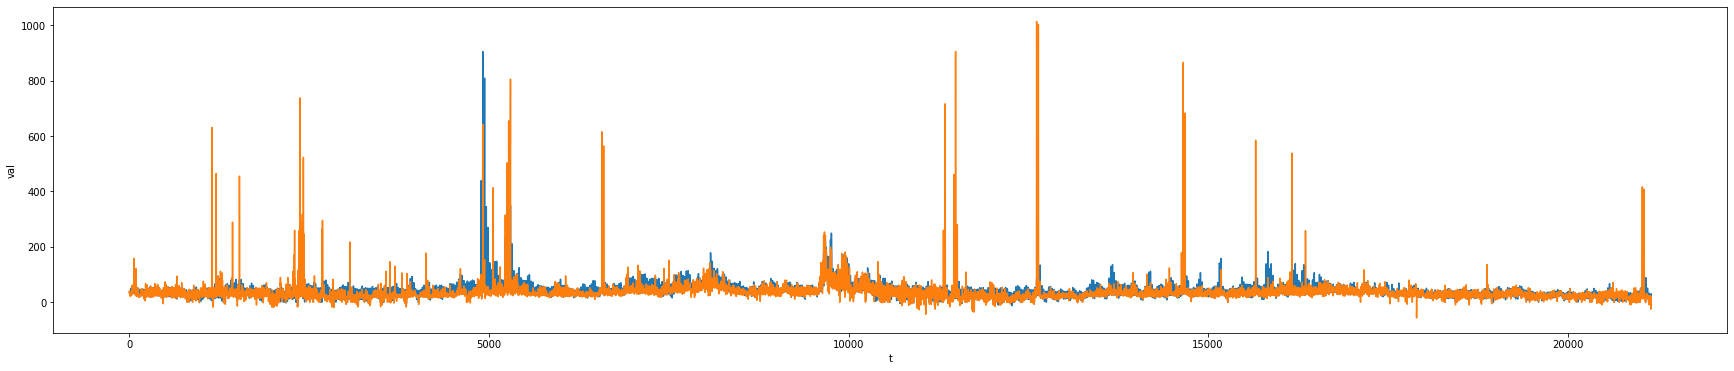

In [99]:
plt.figure(figsize=(30,6))
plt.plot(NP[:,0], NP[:,3])
plt.plot(NP[:,0], NP[:,6])
plt.xlabel("t")
plt.ylabel("val")
plt.show()
plt.close()

**PRE-PROCESSING**

In [100]:
N_spot_max=NP[:,3].max()
N_da_max=NP[:,6].max()
S_spot_max=SP[:,3].max()
S_da_max=SP[:,6].max()
Z_spot_max=ZP[:,3].max()
Z_da_max=ZP[:,6].max()

norm_max=(np.array([N_spot_max,S_spot_max,Z_spot_max,N_da_max,S_da_max,Z_da_max])).max()

In [101]:
N_spot_norm=NP[:,3]/(NP[:,3].max())
N_da_norm=NP[:,6]/(NP[:,6].max())
S_spot_norm=SP[:,3]/(SP[:,3].max())
S_da_norm=SP[:,6]/(SP[:,6].max())
Z_spot_norm=ZP[:,3]/(ZP[:,3].max())
Z_da_norm=ZP[:,6]/(ZP[:,6].max())

In [102]:
iterate=[]
for i in NP[:,3]:
    iterate=iterate+[[i]]

In [169]:
from sklearn.preprocessing import MinMaxScaler
np_iter=np.array(iterate)
max_abs_scaler = MinMaxScaler(feature_range=(-1, 1))
price_norm = max_abs_scaler.fit_transform(x)

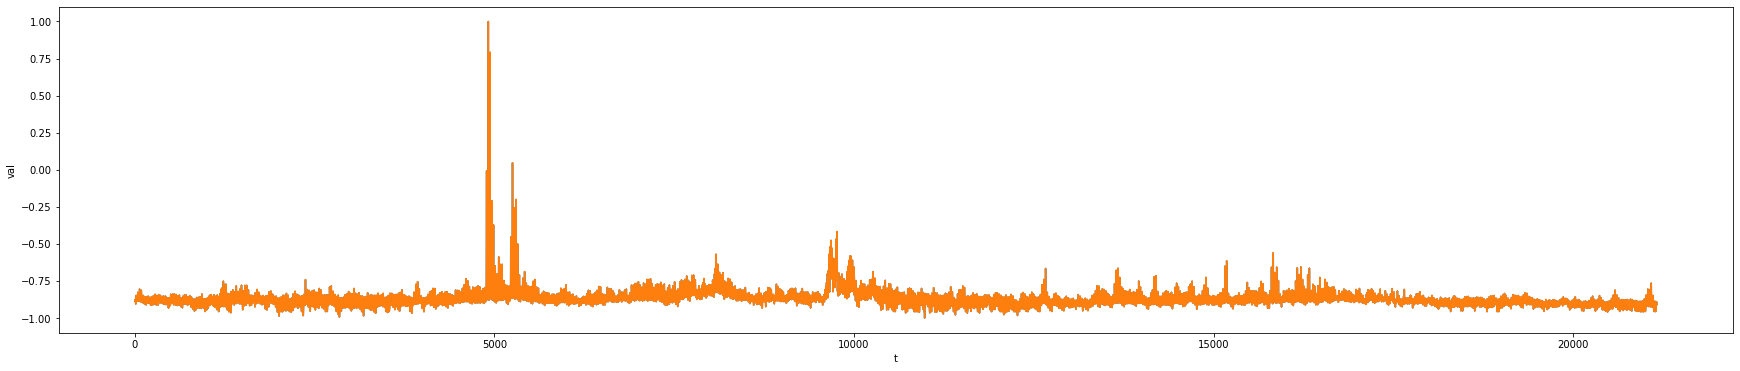

In [105]:
plt.figure(figsize=(30,6))
plt.plot(NP[:,0], price_norm)
plt.plot(NP[:,0], price_norm)
plt.xlabel("t")
plt.ylabel("val")
plt.show()

**MODEL ARCHITECHTURE**

In [166]:
def split_data(stock, lookback):
    data_raw = stock
    data = []
    
    # create all possible sequences of length seq_len
    for index in range(len(data_raw) - lookback): 
        data.append(data_raw[index: index + lookback])
    
    data = np.array(data);
    test_set_size = int(np.round(0.2*data.shape[0]));
    train_set_size = data.shape[0] - (test_set_size);
    
    x_train = data[:train_set_size,:-1,:]
    y_train = data[:train_set_size,-1,:]
    
    x_test = data[train_set_size:,:-1]
    y_test = data[train_set_size:,-1,:]
    
    return [x_train, y_train, x_test, y_test]
lookback = 20 # choose sequence length
x_train, y_train, x_test, y_test = split_data(x, lookback)
print(len(x_train))
print(len(y_train))
print(len(x_test))
print(len(y_test))

16915
16915
4229
4229


In [172]:
x_train

array([[[36.45],
        [34.76],
        [32.85],
        ...,
        [38.05],
        [50.18],
        [48.37]],

       [[34.76],
        [32.85],
        [31.65],
        ...,
        [50.18],
        [48.37],
        [50.48]],

       [[32.85],
        [31.65],
        [31.8 ],
        ...,
        [48.37],
        [50.48],
        [42.73]],

       ...,

       [[44.06],
        [42.64],
        [38.45],
        ...,
        [33.47],
        [34.25],
        [37.63]],

       [[42.64],
        [38.45],
        [35.33],
        ...,
        [34.25],
        [37.63],
        [40.14]],

       [[38.45],
        [35.33],
        [36.32],
        ...,
        [37.63],
        [40.14],
        [43.91]]])

In [134]:
import torch
import torch.nn as nn
x_train = torch.from_numpy(x_train).type(torch.Tensor)
x_test = torch.from_numpy(x_test).type(torch.Tensor)
y_train_lstm = torch.from_numpy(y_train).type(torch.Tensor)
y_test_lstm = torch.from_numpy(y_test).type(torch.Tensor)
y_train_gru = torch.from_numpy(y_train).type(torch.Tensor)
y_test_gru = torch.from_numpy(y_test).type(torch.Tensor)

In [143]:
input_dim = 1
hidden_dim = 24
num_layers = 2
output_dim = 1
num_epochs = 100

**LSTM**

In [110]:
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        out = self.fc(out[:, -1, :]) 
        return out

In [111]:
model1 = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)
criterion = torch.nn.MSELoss(reduction='mean')
optimiser = torch.optim.Adam(model.parameters(), lr=0.01)

In [ ]:
import time
hist = np.zeros(num_epochs)
start_time = time.time()
lstm = []
for t in range(num_epochs):
    y_train_pred = model(x_train)
    loss = criterion(y_train_pred, y_train_lstm)
    print("Epoch ", t, "MSE: ", loss.item())
    hist[t] = loss.item()
    optimiser.zero_grad()
    loss.backward()
    optimiser.step()
    
training_time = time.time()-start_time
print("Training time: {}".format(training_time))

**GRU**

In [144]:
class GRU(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(GRU, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        self.gru = nn.GRU(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        out, (hn) = self.gru(x, (h0.detach()))
        out = self.fc(out[:, -1, :]) 
        return out


In [146]:
model2 = GRU(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)
criterion = torch.nn.MSELoss(reduction='mean')
optimiser = torch.optim.Adam(model.parameters(), lr=.1)

In [147]:
import time
hist = np.zeros(num_epochs)
start_time = time.time()
gru = []
for t in range(num_epochs):
    y_train_pred = model(x_train)
    loss = criterion(y_train_pred, y_train_gru)
    print("Epoch ", t, "MSE: ", loss.item())
    hist[t] = loss.item()
    optimiser.zero_grad()
    loss.backward()
    optimiser.step()
    
training_time = time.time()-start_time
print("Training time: {}".format(training_time))

Epoch  0 MSE:  869.7633666992188
Epoch  1 MSE:  830.305419921875
Epoch  2 MSE:  798.3228149414062
Epoch  3 MSE:  773.8201904296875
Epoch  4 MSE:  756.599609375
Epoch  5 MSE:  746.17822265625
Epoch  6 MSE:  741.704833984375
Epoch  7 MSE:  741.9263916015625
Epoch  8 MSE:  745.2568359375
Epoch  9 MSE:  749.9873657226562
Epoch  10 MSE:  754.5838012695312
Epoch  11 MSE:  757.9439086914062
Epoch  12 MSE:  759.5101318359375
Epoch  13 MSE:  759.2221069335938
Epoch  14 MSE:  757.37890625
Epoch  15 MSE:  754.48095703125
Epoch  16 MSE:  751.0957641601562
Epoch  17 MSE:  747.7576904296875
Epoch  18 MSE:  744.9003295898438
Epoch  19 MSE:  742.8142700195312
Epoch  20 MSE:  741.6290893554688
Epoch  21 MSE:  741.3162231445312
Epoch  22 MSE:  741.7139892578125
Epoch  23 MSE:  742.5717163085938
Epoch  24 MSE:  743.6015625
Epoch  25 MSE:  744.5370483398438
Epoch  26 MSE:  745.1765747070312
Epoch  27 MSE:  745.4108276367188
Epoch  28 MSE:  745.226806640625
Epoch  29 MSE:  744.6944580078125
Epoch  30 MSE: 

KeyboardInterrupt: ignored

**PREDICTION**

In [ ]:
criterion = nn.MSELoss()
def get_accuracy(model, data):
    right, tot = 0, 0
    for sms, label in data:
        out = model(sms[0])
        guess = out.max(1, keepdim=True)[1]
        right += guess.eq(label.view_as(guess)).sum().item()
        tot += label.shape[0]
    loss = criterion(out, label)
    return right / tot, float(loss)

In [ ]:
def plot_model(model, data):
  for i in data:
      out=model(data)
      

In [170]:
out=(model2(np_iter))
out2=out.detach().numpy()
#outp=max_abs_scaler.inverse_transform(out2)

TypeError: ignored

In [149]:
b=[]
c=[]
for i in range(0,4229):
    b=b+[i]
    c=c+[outp[i][0]]

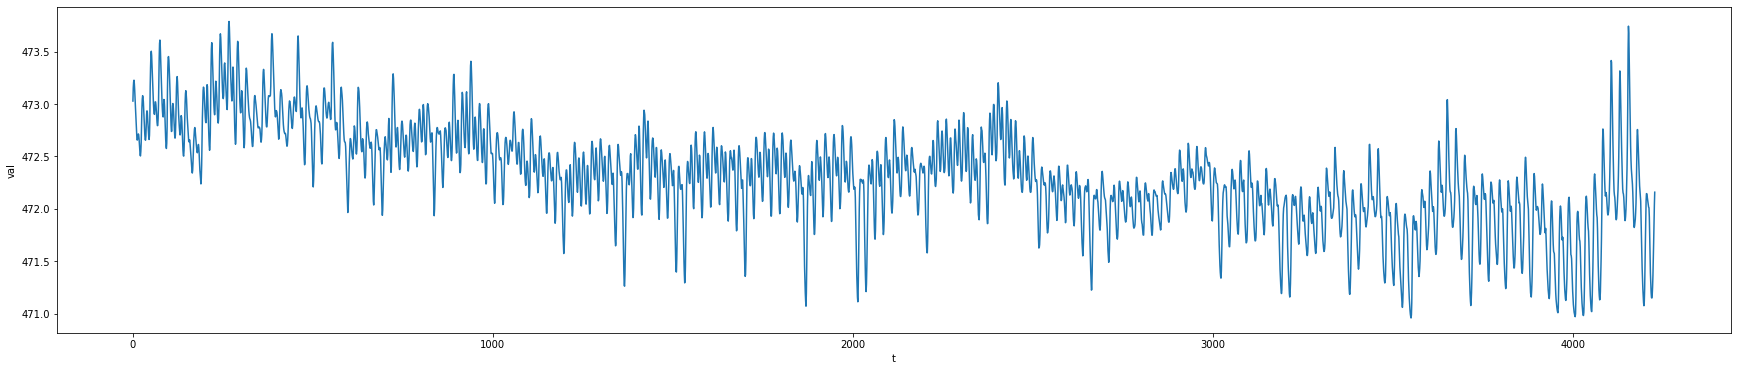

In [150]:
plt.figure(figsize=(30,6))
plt.plot(b, c)
plt.xlabel("t")
plt.ylabel("val")
plt.show()